In [1]:
from pylab import *
from scipy import *
from matplotlib.colors import LogNorm
from matplotlib import colors
from IPython.display import Image
from scipy.integrate import quad
from scipy import interpolate
from scipy.special import jn
from scipy.misc import derivative
from scipy.integrate import nquad

In [2]:
data_mean = loadtxt('/Users/jia/weaklensing/gplus/fulle_bins2D_cross_jk_final.dat')[:,5].reshape(25,-1).T
rp_bins = loadtxt('/Users/jia/weaklensing/gplus/fulle_bins2D_cross_jk_final.dat')[:,0].reshape(25,-1).T
pi_bins = loadtxt('/Users/jia/weaklensing/gplus/fulle_bins2D_cross_jk_final.dat')[:,1].reshape(25,-1).T

In [3]:
## make a reflection for negative r 
data_mean2=concatenate([data_mean,data_mean])
rp_bins2=concatenate([rp_bins,-rp_bins])
pi_bins2=concatenate([pi_bins,pi_bins])

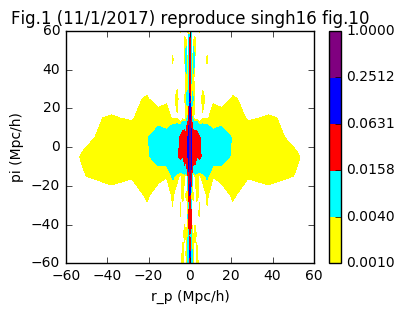

In [4]:
icolors=['yellow','cyan','red','blue','purple']
bounds=logspace(-3,0,6)

f=figure(figsize=(4,3))
ax=f.add_subplot(111)
CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds,colors=icolors)
ax.set_ylim(-60,60)
cbar = plt.colorbar(CS)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.set_title('Fig.1 (11/1/2017) reproduce singh16 fig.10')
show()

<img src="fig10b.jpg" style="width: 400px" align="left">

In [5]:
## dndz
#allz = loadtxt('../lowz/lowz.dat').T[2]
#print amax(allz),amin(allz) #0.16-0.36
#nz, zedges=histogram(allz, bins=linspace(zmin,zmax,51))
#istep = zedges[1]-zedges[0]
#zcenter = zedges [:-1] + 0.5 * istep
#dndz = nz.astype(float)/sum(nz)/istep
#save('dndz_lowz.npy',[zcenter,dndz])

In [6]:
zmin,zmax = 0.16, 0.36
zcenter,dndz = load('dndz_lowz.npy')
pz = interpolate.interp1d(zcenter,dndz,bounds_error=0,fill_value=0.)
zarr=linspace(0.1,0.4,1000)
pz_test = pz(zarr)

In [7]:
## cosmology WMAP9
h = 0.7
H0 = h*100
ob = 0.046
oc = 0.236
om = ob+oc
ol = 1-om#0.718
ns = 0.9646
s8 = 0.817

In [8]:
### constants and small functions
c = 299792.458#km/s
Gnewton = 6.674e-8#cgs cm^3/g/s^2

H = lambda z: H0*sqrt(om*(1+z)**3+ol)
H_inv = lambda z:  1/(H0*sqrt(om*(1+z)**3+ol))
Hcgs = lambda z: H(z)*3.24e-20
DC = lambda z: c*quad(H_inv, 0, z)[0]
W_fcn = lambda z: (pz(z) / DC(z))**2 / c * H(z) # dchi/dz = c/H
rho_cz = lambda z: 0.375*Hcgs(z)**2/pi/Gnewton

In [9]:
Wnorm = quad(W_fcn, zmin, zmax) [0]
W_arr = array([W_fcn(iz)/Wnorm for iz in zarr])
W = interpolate.interp1d(zarr,W_arr,bounds_error=0,fill_value=0.)

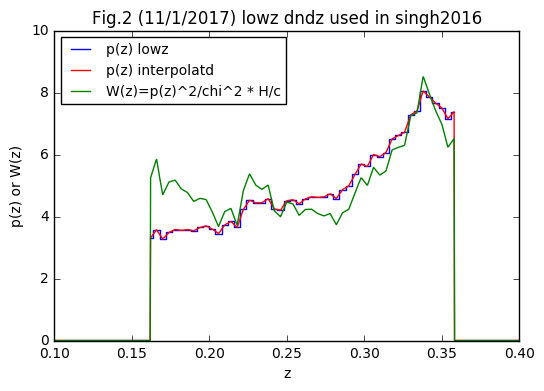

In [10]:
plot(zcenter, dndz, drawstyle='steps-mid',label='p(z) lowz')
plot(zarr,pz_test, 'r',label='p(z) interpolatd')
plot(zarr,W_arr, 'g',label='W(z)=p(z)^2/chi^2 * H/c')
xlabel('z')
ylabel('p(z) or W(z)')
ylim(0,10)
legend(fontsize=10,loc=0)
title('Fig.2 (11/1/2017) lowz dndz used in singh2016')
show()

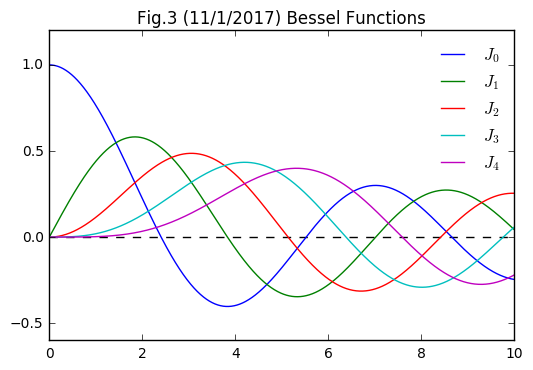

In [11]:
xarr=linspace(0,10,1001)
plot(xarr,zeros(len(xarr)),'k--')
for i in range(5):
    plot(xarr,jn(i,xarr),label='$J_%s$'%(i))
legend(frameon=0)
title('Fig.3 (11/1/2017) Bessel Functions')
show()

In [12]:
## interpolate Pk
Ptable = genfromtxt('/Users/jia/weaklensing/cmblensing/P_delta_Hinshaw')
aa = array([1/1.05**i for i in arange(33)])
zz = 1.0/aa-1 # redshifts
kk = Ptable.T[0] ## Mpc/h
iZ, iK = meshgrid(zz,kk)
Z, K = iZ.flatten(), iK.flatten()
Pk = Ptable[:,1:34].flatten()

### interpolate on actual k and P, without the h
Pmatter_interp = interpolate.CloughTocher2DInterpolator(array([K*h, Z]).T, 2.0*pi**2*Pk/(K*h)**3)
Pmatter = lambda k, z: Pmatter_interp (k, z)

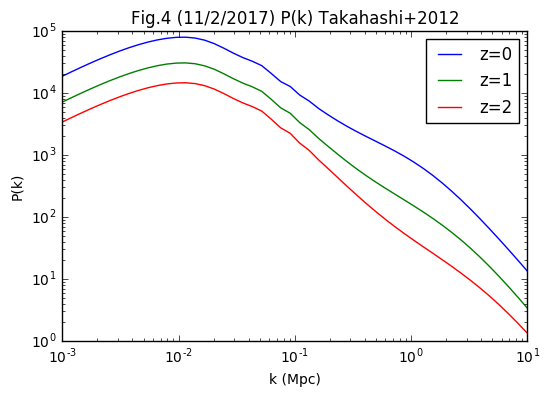

In [13]:
karr = logspace(-3,1)
f = figure()
ax=f.add_subplot(111)
for iz in linspace(0,2,3):
    ax.plot(karr, Pmatter(karr,iz),label='z=%i'%(iz))
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('k (Mpc)')
ax.set_ylabel('P(k)')
title('Fig.4 (11/2/2017) P(k) Takahashi+2012')
show()

In [14]:
## growth D(a)
zarr1=linspace(0,1,1001)
az = lambda z: 1.0/(1.0+z)
za = lambda a: 1.0/a-1
D_fcn = lambda a: H(za(a))/H0 * quad(lambda a: (om/a+ol*a**2)**(-1.5), 0, a)[0]
D1 = D_fcn(1)
D_arr = array([D_fcn (az(iz)) for iz in zarr1])/D1

###### logrithmic growth f=dln(D)/dln(a)
###### first do dD/da then x a/D
dnda_arr = array([derivative(D_fcn, az(iz), dx=1e-5) for iz in zarr1])
f_arr = az(zarr1)/D_arr * dnda_arr

Dinterp = interpolate.interp1d(zarr1,D_arr,bounds_error=0,fill_value=0.)
finterp = interpolate.interp1d(zarr1,f_arr,bounds_error=0,fill_value=0.)

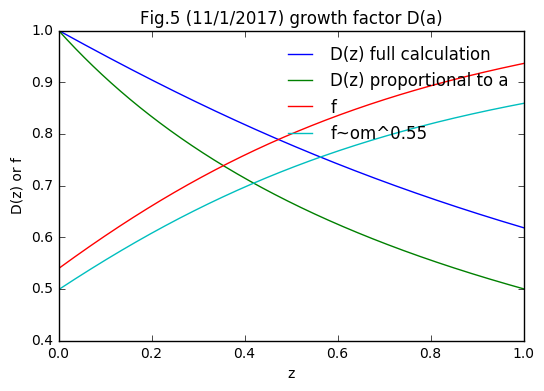

In [15]:
plot(zarr1,D_arr,label='D(z) full calculation')
plot(zarr1,az(zarr1),label='D(z) proportional to a')
plot(zarr1,f_arr,label='f')
plot(zarr1,(om*(1+zarr1)**3/ (H(zarr1)/H0)**2) ** .55 , label='f~om^0.55')
xlabel('z')
ylabel('D(z) or f')
legend(frameon=0)
title('Fig.5 (11/1/2017) growth factor D(a)')
show()

In [17]:
irp=10
iPI=10
kz_arr = [xi_gp(ikz,-3,0.25,irp,iPI) for ikz in linspace(-5,1,7)]
print kz_arr,linspace(-5,1,7)

[0.13670688479354376, 0.013648756108131023, 0.0011111157955454591, 7.9286989823107687e-06, 5.911994844428537e-10, -5.7665504430919874e-14, 9.7020709066441698e-19] [-5. -4. -3. -2. -1.  0.  1.]


In [21]:
rp_arr = linspace(0.5, 60.5, 21)
Pi_arr = linspace(0.5, 60, 15)
rppi_arr = [[irp, ipi] for irp in rp_arr for ipi in Pi_arr]

out=load('out.npy').reshape(21,15).T


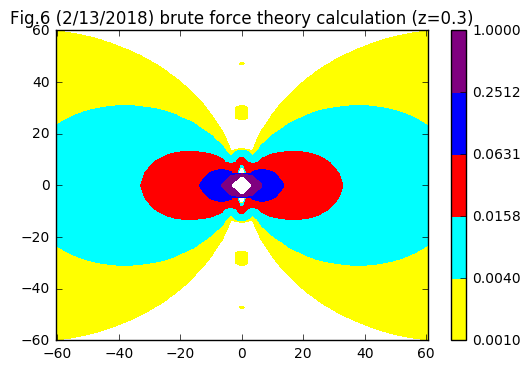

In [40]:
rp_bins_theory = list(-rp_arr[::-1])+list(rp_arr)
pi_bins_theory = list(-Pi_arr[::-1])+list(Pi_arr)

out_mirror = zeros((30,42))
out_mirror[:15,21:]=out[::-1]
out_mirror[15:,21:]=out
out_mirror[:,:21]=out_mirror[:,21:][:,::-1]

#imshow(out_mirror,interpolation='nearest')

CS1=contourf(rp_bins_theory, pi_bins_theory, out_mirror, bounds,colors=icolors)
colorbar(CS)
title('Fig.6 (2/13/2018) brute force theory calculation (z=0.3)')
show()

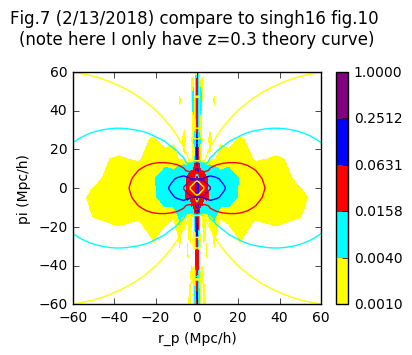

In [45]:
f=figure(figsize=(4,3))
ax=f.add_subplot(111)
CS=ax.contourf(rp_bins2, pi_bins2, data_mean2, bounds,colors=icolors)
ax.set_ylim(-60,60)
cbar = plt.colorbar(CS)
ax.set_xlim(-60,60)
ax.set_xlabel('r_p (Mpc/h)')
ax.set_ylabel('pi (Mpc/h)')
ax.contour(rp_bins_theory, pi_bins_theory, out_mirror, bounds,colors=icolors)
ax.set_title('Fig.7 (2/13/2018) compare to singh16 fig.10 \n(note here I only have z=0.3 theory curve)\n')
show()

In [138]:
C1rhoc = 0.0134 #C1*rho_crit
bD = 1.77 #LOWZ measurement

kabs = lambda kz, kp: sqrt(kz**2+kp**2)
Ai=4.4
const = Ai*bD*C1rhoc*om/2.0/pi**2

In [152]:
xi_gp = lambda kz,kp,rp,PI,z:cos(kz*PI)*kp**3/(kp**2+kz**2)*Pmatter(kabs(kz,kp),z)*jn(2,kp*rp)*(1.0+finterp(z)/bD*kz**2/(kp**2+kz**2))

In [155]:
## bruteforce integration
kabs = lambda kz, kp: sqrt(kz**2+kp**2)
def xi_brute (kz,kp,rp=10.0,PI=10.0,z=0.3):
    k=kabs(kz,kp)
    mu2=(kz/k)**2
    out=(1-mu2)*kp*Pmatter(k,z)*jn(2,kp*rp)*(1.0+finterp(z)/bD*mu2)
    out*=cos(kz*PI)
    return out

## there is no Wz/Dz*const included in this

In [156]:
print xi_gp(0.1,0.1,rp=10.,PI=10.,z=0.3)
print xi_brute(0.1,0.1,rp=10.,PI=10.,z=0.3)

17.6021295524
17.6021295524


In [158]:
def itest (nbin = 501):
    z=0.3
    ilogkz = linspace(-4, 2,nbin)
    ilogkp = linspace(-4, 2,nbin)
    logkzkp = meshgrid(ilogkz,ilogkp)
    logkz, logkp = array(logkzkp).reshape(2,-1)
    dlnkz = ilogkz[1]-ilogkz[0]
    dlnkp = ilogkp[1]-ilogkp[0]
    
    def xi_int (z,rp,PI):
        xi_arr = xi_gp(10**logkz, 10**logkp,rp,PI,z)
        out = sum(xi_arr * 10**logkz * 10**logkp) * dlnkp * dlnkz
        return out

    out = xi_int (z,10.,10.)
    return out

for nn in (101,501, 1001, 2001, 3001,5001,10001):
    print nn, itest(nn)

 101 -1.45521027167
501 0.439095096475
1001 -0.870505775137
2001 0.270286010055
3001 0.494463644954
5001 0.494348278499
10001 0.494373640094


In [159]:
####TEST DIFFERENT KMIN KMAX
def itest (nbin = 501):
    z=0.3
    ilogkz = linspace(-3, 1,nbin)
    ilogkp = linspace(-3, 1,nbin)
    logkzkp = meshgrid(ilogkz,ilogkp)
    logkz, logkp = array(logkzkp).reshape(2,-1)
    dlnkz = ilogkz[1]-ilogkz[0]
    dlnkp = ilogkp[1]-ilogkp[0]
    
    def xi_int (z,rp,PI):
        xi_arr = xi_gp(10**logkz, 10**logkp,rp,PI,z)
        out = sum(xi_arr * 10**logkz * 10**logkp) * dlnkp * dlnkz
        return out

    out = xi_int (z,10.,10.)
    return out

for nn in (101,501, 1001, 2001, 3001,5001,10001):
    print nn, itest(nn)

101 -1.59555392517
501 0.485338866156
1001 0.484420083808
2001 0.48368230966
3001 0.483421795189
5001 0.483211921377
10001 0.483054690711


In [163]:
########## linear bins

def itest_linear (nbin = 501):
    z=0.3
    ik = linspace(1e-3, 10,nbin)
    kzkp = meshgrid(ik,ik)
    kz_arr, kp_arr = array(kzkp).reshape(2,-1)
    dk = ik[1]-ik[0]
    
    def xi_int (rp,PI,z):
        xi_arr = xi_gp(kz_arr, kp_arr,rp,PI,z)
        out = sum(xi_arr) * dk**2
        return out

    out = xi_int (10.,10.,z=0.3)
    return out

for nn in (101,501, 1001, 2001, 3001,5001,10001):
    print nn, itest_linear(nn)

 101 5.49568508218
501 3.14094705451
1001 2.8504796615
2001 2.70532504616
3001 2.65696858912
5001 2.61829254746
10001 2.58928469757


In [176]:
####TEST log space, but with different dk bins ### look good!
def itest (nbin = 501):
    z=0.3
    ik = logspace(-3, 1,nbin)
    dk = ik[1:]-ik[:-1]
    ikc = 0.5*(ik[1:]+ik[:-1])
    kz, kp = array(meshgrid(ikc,ikc)).reshape(2,-1)
    dkz, dkp = array(meshgrid(dk,dk)).reshape(2,-1)
    
    def xi_int (z,rp,PI):
        xi_arr = xi_gp(kz,kp,rp,PI,z)
        out = sum(xi_arr*dkz*dkp)
        return out

    out = xi_int (z,10.,10.)
    return out

for nn in (101,501, 1001, 2001, 3001,5001,10001):
    print nn, itest(nn)

101 -3.99264554862
501 2.55718279277
1001 2.5595947562
2001 2.56011247294
3001 2.56020469141
5001 2.560251534
10001 2.56027124678


In [179]:
####TEST log space, kp more bins than kz, since kp is in J2
def itest (nbin = 501):
    z=0.3
    ikp = logspace(-3, 1,5001)
    ikz = logspace(-3, 1,nbin)
    dkp = ikp[1:]-ikp[:-1]
    dkz = ikz[1:]-ikz[:-1]
    ikpc = 0.5*(ikp[1:]+ikp[:-1])
    ikzc = 0.5*(ikz[1:]+ikz[:-1])
    kz, kp = array(meshgrid(ikzc,ikpc)).reshape(2,-1)
    dkz, dkp = array(meshgrid(dkz,dkp)).reshape(2,-1)
    
    def xi_int (z,rp,PI):
        xi_arr = xi_gp(kz,kp,rp,PI,z)
        out = sum(xi_arr*dkz*dkp)
        return out

    out = xi_int (z,10.,10.)
    return out

for nn in (2001, 1001,501,401,301,201,101):
    print nn, itest(nn)

2001 2.56018743082
1001 2.55995327098
501 2.55892200633
401 2.5580366486
301 2.55576124755
201 2.54128495082
101 2.21285646592


In [160]:
##### DO NOT TOUCH THIS CELL, long computing time!!
xi_test=nquad(xi_brute, [[1e-3, 10], [1e-3, 10]])
print xi_test
print xi_test[0]*const/iD

(2.560275104476028, 0.0006904425410461698)
0.00443875234851


In [194]:
### ok 1001 bins seems to give reasonable results 
### now let's see the redshift evolution

def itest_z (z=0.3):
    #print z
    ik = logspace(-3, 1,1001)
    dk = ik[1:]-ik[:-1]
    ikc = 0.5*(ik[1:]+ik[:-1])
    kz, kp = array(meshgrid(ikc,ikc)).reshape(2,-1)
    dkz, dkp = array(meshgrid(dk,dk)).reshape(2,-1)
    
    def xi_int (z,rp,PI):
        xi_arr = xi_gp(kz,kp,rp,PI,z)
        out = sum(xi_arr*dkz*dkp)
        return out

    out = xi_int (z,9.5,9.)
    return out

In [196]:
z_arr = linspace(zmin,zmax,21)
out_arr =array([itest_z(z) for z in z_arr])

0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36


In [197]:
print out_arr

[ 3.75684398  3.7073015   3.65878405  3.61064446  3.562854    3.51602756
  3.47046857  3.42562964  3.38106146  3.33628162  3.29144576  3.24753509
  3.20555443  3.16515008  3.12577552  3.08676489  3.04807059  3.00982855
  2.97203352  2.93457213  2.89768753]


In [204]:
## xi_arr/rp9.50_Pi9.00.out
## 2.777899258198952837e-02
dz=z_arr[1]-z_arr[0]
print out_arr[-7]*const
print sum(out_arr*W(z_arr)/Dinterp(z_arr))*dz*const

0.00466023582733
0.0053748296382


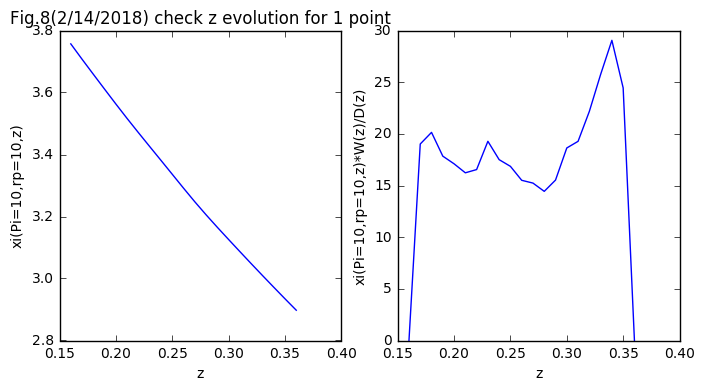

In [335]:
f=figure(figsize=(8,4))
ax=f.add_subplot(121)
ax2=f.add_subplot(122)
ax.plot(z_arr, out_arr)
ax.set_xlabel('z')
ax.set_ylabel('xi(Pi=10,rp=10,z)')
ax.set_title('Fig.8(2/14/2018) check z evolution for 1 point')
ax2.plot(z_arr, out_arr*W(z_arr)/Dinterp(z_arr))
ax2.set_xlabel('z')
ax2.set_ylabel('xi(Pi=10,rp=10,z)*W(z)/D(z)')

show()

In [255]:
############## learn about FFT!!

signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
fourier = np.fft.fft(signal)
timestep = 1
freq = np.fft.fftfreq(signal.size, d=timestep)
print 'signal:',signal
print 'inverse fft:',real(ifft(fourier))
print freq

for x in range(len(signal)):
    print x, signal[x], sum(fourier*exp(1j*2*pi*x*freq))/8.

signal: [-2.  8.  6.  4.  1.  0.  3.  5.]
inverse fft: [-2.  8.  6.  4.  1.  0.  3.  5.]
[ 0.     0.125  0.25   0.375 -0.5   -0.375 -0.25  -0.125]
0 -2.0 (-2+0j)
1 8.0 (8-1.19348975147e-15j)
2 6.0 (6-1.7763568394e-15j)
3 4.0 (4+1.11022302463e-15j)
4 1.0 (1-5.55111512313e-16j)
5 0.0 (1.33226762955e-15+2.02615701994e-15j)
6 3.0 (3+7.77156117238e-16j)
7 5.0 (5+4.4408920985e-16j)


In [345]:
## 2/14-17 try marko's fft method
#imin,imax=95,284##### 95-283 is in the range 1e-3 and 10
imin,imax=0,378
Pk_arr2 = Ptable[imin:imax,1:34] ### has shape (378, 33)
kk2 = Ptable.T[0][imin:imax] ### has shape 378, log spaced between 1e-5 to 9.736e2

ikPk = kk2*Pk_arr2.T[2]
Nk=len(ikPk)
ikPk_fft = fft(ikPk)#[:Nk/2]
klogstep=log(1.05)##mean(log(kk2)[1:]-log(kk2)[:-1]) ## or log(kmax/kmin)/(Nk-1)

In [346]:
jjj=100
ik = kk2[jjj]
kmin,kmax=kk2[0],kk2[-1]
ip = ikPk[jjj]
ifreq = fftfreq(Nk)#[:Nk/2]##d=klogstep
ilogk = log(kk2[jjj])
nun = fftfreq(Nk, d=klogstep)

###  from nicea lensingdemo.c: for (k=0.00001; k<=1000.0; k*=1.05) 
### so dlogk should be 0.05

print 'dlogk:', log(kmax/kmin)/(Nk-1), klogstep

print '(1)log(ik):',log(ik)
print '(2)ifft:',ip, sum(ikPk_fft*exp(1j*2*pi*jjj*ifreq))/Nk

print '(3)10*klogstep',sum(ikPk_fft*exp(1j*2*pi*(jjj*klogstep)*nun))/Nk

#print '(4)10*klogstep, ilogk-log(kmin):',jjj*klogstep, ilogk-log(kmin)
#print '(5)booo:',10*klogstep / 0.487901641694

print '(4)ilogk-log(kmin)',x,sum(ikPk_fft*exp(1j*2*pi*(ilogk-log(kmin))*nun))/Nk

print '(5)marko method(power):',sum(ikPk_fft*kmin**(-1j*2*pi*nun)*kk2[jjj]**(1j*2*pi*nun))/Nk

print 'successful!!'

dlogk: 0.0487901642064 0.0487901641694
(1)log(ik): -6.63390872747
(2)ifft: 8.12240923679e-10 (-8.8303177445e-09-3.94210613594e-11j)
(3)10*klogstep (-3.94210613594e-11+5.32184328352e-10j)
(4)ilogk-log(kmin) 4.87901622123 (-0.238860790376+0.264133234602j)
(5)marko method(power): (-0.238860795067+0.264133235193j)
successful!!


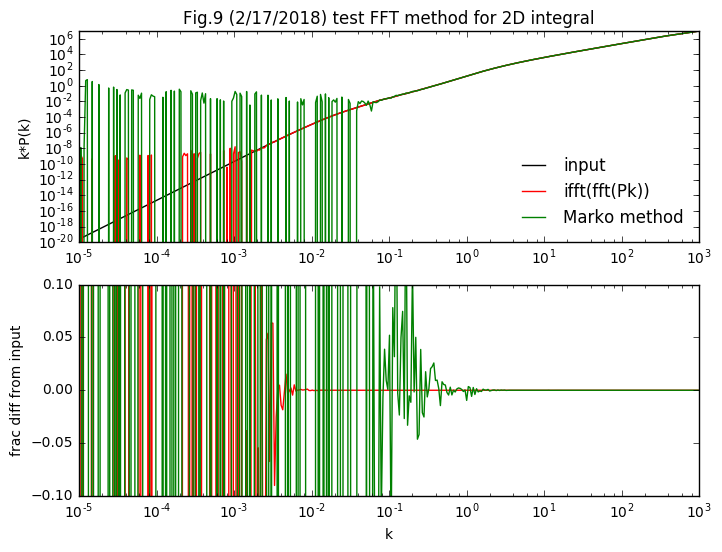

In [347]:
########## now compare how accurate marko's integration is
#kk2, Pk_arr2.T[2]
Pk0 = kk2*Pk_arr2.T[2]
Pk_ifft = array([sum(ikPk_fft*exp(1j*2*pi*jjj*ifreq))/Nk for jjj in arange(Nk)])
Pk_marko = array([sum(ikPk_fft*kmin**(-1j*2*pi*nun)*kk2[jjj]**(1j*2*pi*nun))/Nk for jjj in arange(Nk)])

f=figure(figsize=(8,6))
ax=f.add_subplot(211)
ax2=f.add_subplot(212)
ax.plot(kk2, Pk0,'k-',label='input')
ax.plot(kk2, Pk_ifft, 'r-',label='ifft(fft(Pk))')
ax.plot(kk2, Pk_marko,'g-',label='Marko method')
ax.set_xscale('log')
ax.set_ylabel('k*P(k)')
ax.set_yscale('log')
ax.legend(frameon=0,loc=0)
ax.set_title('Fig.9 (2/17/2018) test FFT method for 2D integral')
ax2.plot(kk2, Pk_ifft/Pk0-1, 'r-',label='ifft(fft(Pk))')
ax2.plot(kk2, Pk_marko/Pk0-1, 'g-',label='Marko method')
ax2.set_xscale('log')
ax2.set_ylim(-0.1,0.1)
ax2.set_xlabel('k')
ax2.set_ylabel('frac diff from input')
show()

In [ ]:
nun = fftfreq(Nk,d=klogstep)[:Nk/2]


Cn = ikPk_fft
#plot(ifreq, real(ikPk_fft),'r-')
#plot(ifreq, imag(ikPk_fft),'b-')
#show()

from scipy import special
ga = special.gamma

def xi_marko(irp, iPi): 
    numerator = Cn*ga(nun+3.0)*cos(pi*nun/2.0)*irp**2
    denominator = (1.0-nun**2)*(iPi**2+irp**2)**(2.0+nun/2.0)
    return sum(numerator/denominator)

print xi_marko(10.,10.)

In [174]:
xi_gp1term = lambda kz,kp,rp,PI,z:cos(kz*PI)*kp**3/(kp**2+kz**2)*Pmatter(kabs(kz,kp),z)*jn(2,kp*rp)

In [175]:
########## use only 1 terms to compare with marko's code
def itest_1term (nbin = 501):
    z=0.3
    ik = linspace(1e-3, 10,nbin)
    kzkp = meshgrid(ik,ik)
    kz_arr, kp_arr = array(kzkp).reshape(2,-1)
    dk = ik[1]-ik[0]
    
    def xi_int (rp,PI,z):
        xi_arr = xi_gp1term(kz_arr, kp_arr,rp,PI,z)
        out = sum(xi_arr) * dk**2
        return out

    out = xi_int (10.,10.,z=0.3)
    return out

for nn in (101,501, 1001, 2001, 3001,5001):
    print '1term',nn, itest_1term(nn)

1term 101 5.83386334203
1term 501 3.4698815987
1term 1001 3.17950384603
1term 2001 3.0344109236
1term 3001 2.98607697934
1term 5001 2.94741968987
